In [1]:
import os
import numpy as np
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, TimeDistributed, LSTM, BatchNormalization # Added BatchNormalization
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tqdm import tqdm
from keras.utils import Sequence

# Define your directories
data_dir = os.path.join(os.path.expanduser("~"), "Desktop", "cse499b", "Extracted_landmarks_temp")

# Define the image dimensions
img_width, img_height = 128, 128
num_channels = 3
batch_size = 16
epochs = 15
learning_rate = 0.001

# Define the number of classes
classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
num_classes = len(classes)
print("Total number of classes:", num_classes)



Total number of classes: 120


In [2]:
# Define the number of subsets
num_subsets = 12

# Divide classes into subsets
classes_subsets = [classes[i:i + num_classes // num_subsets] for i in range(0, num_classes, num_classes // num_subsets)]
print(len(classes_subsets))

# Define the sequence length (number of frames per sequence)
sequence_length = 30

# Define arrays to store training and validation loss and accuracy
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Define arrays to store best validation accuracies for each subset
subset_best_val_accuracies = []

# Define a custom data generator to handle sequences of frames
class SequenceDataGenerator(Sequence):
    def __init__(self, data_dir, classes, sequence_length, img_width, img_height, batch_size, split_type):
        self.data_dir = data_dir
        self.classes = classes
        self.sequence_length = sequence_length
        self.img_width = img_width
        self.img_height = img_height
        self.batch_size = batch_size
        self.split_type = split_type

        # Prepare file paths and labels
        self.file_paths, self.labels = self._prepare_file_paths_and_labels()

        # Shuffle data
        self.on_epoch_end()

    def _prepare_file_paths_and_labels(self):
        file_paths = []
        labels = []
        for label_idx, class_name in enumerate(self.classes):
            class_dir = os.path.join(self.data_dir, class_name)
            video_folders = [f for f in os.listdir(class_dir) if os.path.isdir(os.path.join(class_dir, f))]

            # Wrap the loop with tqdm to display progress
            for video_folder in tqdm(video_folders, desc=f"Processing {class_name}", unit="video"):
                video_dir = os.path.join(class_dir, video_folder)
                frame_files = sorted([os.path.join(video_dir, f) for f in os.listdir(video_dir)])
                if len(frame_files) >= self.sequence_length:
                    file_paths.append(frame_files[:self.sequence_length])
                    labels.append(label_idx)

        return file_paths, labels

    def __len__(self):
        # Return the number of batches per epoch
        return len(self.file_paths) // self.batch_size

    def __getitem__(self, index):
        # Prepare batch data and labels
        start_index = index * self.batch_size
        end_index = start_index + self.batch_size

        # Prepare arrays for data and labels
        batch_data = np.zeros((self.batch_size, self.sequence_length, self.img_width, self.img_height, 3))
        batch_labels = np.zeros((self.batch_size, len(self.classes)))

        # Use tqdm for tracking progress in data generation
        for i in range(start_index, end_index):
            # Load image data for the batch
            for j in range(self.sequence_length):
                img_path = self.file_paths[i][j]
                img = load_img(img_path, target_size=(self.img_width, self.img_height))
                img_array = img_to_array(img)
                img_array /= 255.0
                batch_data[i - start_index, j] = img_array

            # Set labels for the batch
            label_idx = self.labels[i]
            batch_labels[i - start_index, label_idx] = 1

        return batch_data, batch_labels

    def on_epoch_end(self):
        # Shuffle the data at the end of each epoch
        indices = np.arange(len(self.file_paths))
        np.random.shuffle(indices)
        self.file_paths = np.array(self.file_paths)[indices]
        self.labels = np.array(self.labels)[indices]

12


In [6]:
# Define a function to create the model
def create_model():
    model = Sequential()
    model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=(sequence_length, img_height, img_width, num_channels)))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    model.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(128, dropout=0.5))  # Add dropout to LSTM layer
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))  # Add dropout to dense layer
    model.add(Dense(10, activation='softmax'))  # Output layer with number of classes units
    return model

# Initialize the model
model = create_model()

In [7]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

# Define your preferred directory
save_dir = 'Desktop/cse499b/frames_model'

# Make sure the directory exists
os.makedirs(save_dir, exist_ok=True)

# Train the model on subsets of classes
best_val_accuracies = []
for i, class_subset in enumerate(classes_subsets):
    print(f"\nTraining model for classes subset {i+1}/{len(classes_subsets)}")
    print("Classes in subset:", class_subset)

    # Initialize the training data generator for the subset
    train_generator = SequenceDataGenerator(data_dir, class_subset, sequence_length, img_width, img_height, batch_size, split_type='train')
    # Initialize the validation data generator for the subset
    val_generator = SequenceDataGenerator(data_dir, class_subset, sequence_length, img_width, img_height, batch_size, split_type='val')

    # Define callbacks
    checkpoint_path = os.path.join(save_dir, f'sign_language_model_subset_{i}.h5')
    checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the model
    model.compile(loss='categorical_crossentropy', optimizer=RMSprop(learning_rate=learning_rate), metrics=['accuracy'])
    history = model.fit(train_generator, epochs=epochs, steps_per_epoch=len(train_generator),
                        validation_data=val_generator, validation_steps=len(val_generator),
                        callbacks=[checkpoint, early_stopping])

    # Load the best model and evaluate on validation data
    best_model = load_model(checkpoint_path)
    val_loss, val_accuracy = best_model.evaluate(val_generator, steps=len(val_generator))
    best_val_accuracies.append(val_accuracy)

    # Store training and validation loss and accuracy
    train_losses.append(history.history['loss'])
    train_accuracies.append(history.history['accuracy'])
    val_losses.append(history.history['val_loss'])
    val_accuracies.append(history.history['val_accuracy'])

    # Save best validation accuracy for the subset
    subset_best_val_accuracies.append(val_accuracy)

# Save train/validation data for plotting
train_val_data = {
    'train_losses': train_losses,
    'train_accuracies': train_accuracies,
    'val_losses': val_losses,
    'val_accuracies': val_accuracies
}
train_val_data_path = os.path.join(save_dir, 'train_val_data.npy')
np.save(train_val_data_path, train_val_data)

# Calculate overall best validation accuracy
overall_best_val_accuracy = np.mean(subset_best_val_accuracies)
print(f"Overall best validation accuracy: {overall_best_val_accuracy}")

# Save the final model
final_model_path = os.path.join(save_dir, 'sign_language_final_model.h5')
model.save(final_model_path)



Training model for classes subset 1/12
Classes in subset: ['aam', 'aangti', 'aat', 'abhawa', 'ador', 'agun', 'akash', 'alo', 'amader', 'amar']


Processing amar: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 1769.55video/s]


Epoch 1/15
18/18 [==============================] - ETA: 0s - loss: 2.4230 - accuracy: 0.0972 
Epoch 1: val_accuracy improved from -inf to 0.10417, saving model to Desktop/cse499b/frames_model\sign_language_model_subset_0.h5


D:\anaconda\envs\tf\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


18/18 [==============================] - 599s 32s/step - loss: 2.4230 - accuracy: 0.0972 - val_loss: 2.3102 - val_accuracy: 0.1042
Epoch 2/15
18/18 [==============================] - ETA: 0s - loss: 2.3359 - accuracy: 0.0972 
Epoch 2: val_accuracy did not improve from 0.10417
18/18 [==============================] - 583s 32s/step - loss: 2.3359 - accuracy: 0.0972 - val_loss: 2.3235 - val_accuracy: 0.0972
Epoch 3/15
18/18 [==============================] - ETA: 0s - loss: 2.3330 - accuracy: 0.0729 
Epoch 3: val_accuracy did not improve from 0.10417
18/18 [==============================] - 574s 31s/step - loss: 2.3330 - accuracy: 0.0729 - val_loss: 2.3027 - val_accuracy: 0.0972
Epoch 4/15
18/18 [==============================] - ETA: 0s - loss: 2.3100 - accuracy: 0.0764 
Epoch 4: val_accuracy did not improve from 0.10417
18/18 [==============================] - 301s 17s/step - loss: 2.3100 - accuracy: 0.0764 - val_loss: 2.3027 - val_accuracy: 0.0972
Epoch 5/15
18/18 [====================

Processing bah: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 2236.76video/s]


Epoch 1/15
18/18 [==============================] - ETA: 0s - loss: 2.3135 - accuracy: 0.0833 
Epoch 1: val_accuracy improved from -inf to 0.10417, saving model to Desktop/cse499b/frames_model\sign_language_model_subset_1.h5
18/18 [==============================] - 317s 17s/step - loss: 2.3135 - accuracy: 0.0833 - val_loss: 2.3027 - val_accuracy: 0.1042
Epoch 2/15
18/18 [==============================] - ETA: 0s - loss: 2.3070 - accuracy: 0.1181
Epoch 2: val_accuracy improved from 0.10417 to 0.12153, saving model to Desktop/cse499b/frames_model\sign_language_model_subset_1.h5
18/18 [==============================] - 253s 14s/step - loss: 2.3070 - accuracy: 0.1181 - val_loss: 2.3024 - val_accuracy: 0.1215
Epoch 3/15
18/18 [==============================] - ETA: 0s - loss: 2.3064 - accuracy: 0.0868
Epoch 3: val_accuracy did not improve from 0.12153
18/18 [==============================] - 273s 16s/step - loss: 2.3064 - accuracy: 0.0868 - val_loss: 2.3026 - val_accuracy: 0.0972
Epoch 4/15

Processing bondhu: 100%|██████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 2019.66video/s]


Epoch 1/15
18/18 [==============================] - ETA: 0s - loss: 2.4154 - accuracy: 0.0868 
Epoch 1: val_accuracy improved from -inf to 0.10417, saving model to Desktop/cse499b/frames_model\sign_language_model_subset_2.h5
18/18 [==============================] - 367s 20s/step - loss: 2.4154 - accuracy: 0.0868 - val_loss: 2.3014 - val_accuracy: 0.1042
Epoch 2/15
18/18 [==============================] - ETA: 0s - loss: 2.3150 - accuracy: 0.0868 
Epoch 2: val_accuracy did not improve from 0.10417
18/18 [==============================] - 331s 19s/step - loss: 2.3150 - accuracy: 0.0868 - val_loss: 2.3007 - val_accuracy: 0.1042
Epoch 3/15
18/18 [==============================] - ETA: 0s - loss: 2.3244 - accuracy: 0.0903
Epoch 3: val_accuracy did not improve from 0.10417
18/18 [==============================] - 289s 16s/step - loss: 2.3244 - accuracy: 0.0903 - val_loss: 2.2990 - val_accuracy: 0.0972
Epoch 4/15
18/18 [==============================] - ETA: 0s - loss: 2.3127 - accuracy: 0.08

Processing chair: 100%|███████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 1184.82video/s]


Epoch 1/15
18/18 [==============================] - ETA: 0s - loss: 2.5034 - accuracy: 0.1181 
Epoch 1: val_accuracy improved from -inf to 0.11111, saving model to Desktop/cse499b/frames_model\sign_language_model_subset_3.h5
18/18 [==============================] - 402s 22s/step - loss: 2.5034 - accuracy: 0.1181 - val_loss: 2.3060 - val_accuracy: 0.1111
Epoch 2/15
18/18 [==============================] - ETA: 0s - loss: 2.3376 - accuracy: 0.0833 
Epoch 2: val_accuracy improved from 0.11111 to 0.13194, saving model to Desktop/cse499b/frames_model\sign_language_model_subset_3.h5
18/18 [==============================] - 409s 23s/step - loss: 2.3376 - accuracy: 0.0833 - val_loss: 2.2921 - val_accuracy: 0.1319
Epoch 3/15
18/18 [==============================] - ETA: 0s - loss: 2.3156 - accuracy: 0.1042 
Epoch 3: val_accuracy did not improve from 0.13194
18/18 [==============================] - 390s 21s/step - loss: 2.3156 - accuracy: 0.1042 - val_loss: 2.2799 - val_accuracy: 0.1319
Epoch 4/

Processing choto: 100%|███████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 2906.12video/s]


Epoch 1/15
18/18 [==============================] - ETA: 0s - loss: 2.7964 - accuracy: 0.0729 
Epoch 1: val_accuracy improved from -inf to 0.10764, saving model to Desktop/cse499b/frames_model\sign_language_model_subset_4.h5
18/18 [==============================] - 403s 22s/step - loss: 2.7964 - accuracy: 0.0729 - val_loss: 2.3198 - val_accuracy: 0.1076
Epoch 2/15
18/18 [==============================] - ETA: 0s - loss: 2.3401 - accuracy: 0.0972
Epoch 2: val_accuracy improved from 0.10764 to 0.11806, saving model to Desktop/cse499b/frames_model\sign_language_model_subset_4.h5
18/18 [==============================] - 266s 15s/step - loss: 2.3401 - accuracy: 0.0972 - val_loss: 2.3272 - val_accuracy: 0.1181
Epoch 3/15
18/18 [==============================] - ETA: 0s - loss: 2.3594 - accuracy: 0.0938
Epoch 3: val_accuracy did not improve from 0.11806
18/18 [==============================] - 283s 15s/step - loss: 2.3594 - accuracy: 0.0938 - val_loss: 2.3149 - val_accuracy: 0.1007
Epoch 4/15

Processing doctor: 100%|██████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 1801.44video/s]


Epoch 1/15
18/18 [==============================] - ETA: 0s - loss: 2.5393 - accuracy: 0.0694 
Epoch 1: val_accuracy improved from -inf to 0.11458, saving model to Desktop/cse499b/frames_model\sign_language_model_subset_5.h5
18/18 [==============================] - 379s 20s/step - loss: 2.5393 - accuracy: 0.0694 - val_loss: 2.3085 - val_accuracy: 0.1146
Epoch 2/15
18/18 [==============================] - ETA: 0s - loss: 2.3064 - accuracy: 0.1285 
Epoch 2: val_accuracy did not improve from 0.11458
18/18 [==============================] - 563s 32s/step - loss: 2.3064 - accuracy: 0.1285 - val_loss: 2.3086 - val_accuracy: 0.1007
Epoch 3/15
18/18 [==============================] - ETA: 0s - loss: 2.3223 - accuracy: 0.1319 
Epoch 3: val_accuracy did not improve from 0.11458
18/18 [==============================] - 630s 34s/step - loss: 2.3223 - accuracy: 0.1319 - val_loss: 2.3051 - val_accuracy: 0.0903
Epoch 4/15
18/18 [==============================] - ETA: 0s - loss: 2.3427 - accuracy: 0.0

Processing dustu: 100%|███████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 1594.02video/s]


Epoch 1/15
18/18 [==============================] - ETA: 0s - loss: 2.6407 - accuracy: 0.0590 
Epoch 1: val_accuracy improved from -inf to 0.09722, saving model to Desktop/cse499b/frames_model\sign_language_model_subset_6.h5
18/18 [==============================] - 447s 24s/step - loss: 2.6407 - accuracy: 0.0590 - val_loss: 2.3309 - val_accuracy: 0.0972
Epoch 2/15
18/18 [==============================] - ETA: 0s - loss: 2.3439 - accuracy: 0.0938 
Epoch 2: val_accuracy improved from 0.09722 to 0.10417, saving model to Desktop/cse499b/frames_model\sign_language_model_subset_6.h5
18/18 [==============================] - 348s 19s/step - loss: 2.3439 - accuracy: 0.0938 - val_loss: 2.3020 - val_accuracy: 0.1042
Epoch 3/15
18/18 [==============================] - ETA: 0s - loss: 2.3235 - accuracy: 0.0868 
Epoch 3: val_accuracy did not improve from 0.10417
18/18 [==============================] - 338s 17s/step - loss: 2.3235 - accuracy: 0.0868 - val_loss: 2.3019 - val_accuracy: 0.1042
Epoch 4/

Processing golarhaar: 100%|███████████████████████████████████████████████████████| 30/30 [00:00<00:00, 1623.41video/s]


Epoch 1/15
18/18 [==============================] - ETA: 0s - loss: 2.4203 - accuracy: 0.0799 
Epoch 1: val_accuracy improved from -inf to 0.09722, saving model to Desktop/cse499b/frames_model\sign_language_model_subset_7.h5
18/18 [==============================] - 358s 19s/step - loss: 2.4203 - accuracy: 0.0799 - val_loss: 2.3185 - val_accuracy: 0.0972
Epoch 2/15
18/18 [==============================] - ETA: 0s - loss: 2.3381 - accuracy: 0.0938
Epoch 2: val_accuracy did not improve from 0.09722
18/18 [==============================] - 242s 13s/step - loss: 2.3381 - accuracy: 0.0938 - val_loss: 2.3066 - val_accuracy: 0.0972
Epoch 3/15
18/18 [==============================] - ETA: 0s - loss: 2.3200 - accuracy: 0.0938
Epoch 3: val_accuracy improved from 0.09722 to 0.10069, saving model to Desktop/cse499b/frames_model\sign_language_model_subset_7.h5
18/18 [==============================] - 251s 14s/step - loss: 2.3200 - accuracy: 0.0938 - val_loss: 2.3199 - val_accuracy: 0.1007
Epoch 4/15

Processing jiggasha: 100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 2005.18video/s]


Epoch 1/15
18/18 [==============================] - ETA: 0s - loss: 2.6434 - accuracy: 0.0938 
Epoch 1: val_accuracy improved from -inf to 0.12500, saving model to Desktop/cse499b/frames_model\sign_language_model_subset_8.h5
18/18 [==============================] - 362s 19s/step - loss: 2.6434 - accuracy: 0.0938 - val_loss: 2.2940 - val_accuracy: 0.1250
Epoch 2/15
18/18 [==============================] - ETA: 0s - loss: 2.3462 - accuracy: 0.1007 
Epoch 2: val_accuracy improved from 0.12500 to 0.13542, saving model to Desktop/cse499b/frames_model\sign_language_model_subset_8.h5
18/18 [==============================] - 292s 16s/step - loss: 2.3462 - accuracy: 0.1007 - val_loss: 2.2701 - val_accuracy: 0.1354
Epoch 3/15
18/18 [==============================] - ETA: 0s - loss: 2.3388 - accuracy: 0.1042 
Epoch 3: val_accuracy improved from 0.13542 to 0.17014, saving model to Desktop/cse499b/frames_model\sign_language_model_subset_8.h5
18/18 [==============================] - 290s 16s/step - 

Processing khelowar: 100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 2396.75video/s]


Epoch 1/15
18/18 [==============================] - ETA: 0s - loss: 2.6915 - accuracy: 0.1215 
Epoch 1: val_accuracy improved from -inf to 0.12847, saving model to Desktop/cse499b/frames_model\sign_language_model_subset_9.h5
18/18 [==============================] - 421s 22s/step - loss: 2.6915 - accuracy: 0.1215 - val_loss: 2.3445 - val_accuracy: 0.1285
Epoch 2/15
18/18 [==============================] - ETA: 0s - loss: 2.3633 - accuracy: 0.1007 
Epoch 2: val_accuracy did not improve from 0.12847
18/18 [==============================] - 303s 17s/step - loss: 2.3633 - accuracy: 0.1007 - val_loss: 2.2975 - val_accuracy: 0.1285
Epoch 3/15
18/18 [==============================] - ETA: 0s - loss: 2.3613 - accuracy: 0.0799 
Epoch 3: val_accuracy improved from 0.12847 to 0.14236, saving model to Desktop/cse499b/frames_model\sign_language_model_subset_9.h5
18/18 [==============================] - 314s 18s/step - loss: 2.3613 - accuracy: 0.0799 - val_loss: 2.2669 - val_accuracy: 0.1424
Epoch 4/

Processing maa: 100%|██████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 453.38video/s]


Epoch 1/15
18/18 [==============================] - ETA: 0s - loss: 2.6024 - accuracy: 0.0833 
Epoch 1: val_accuracy improved from -inf to 0.11458, saving model to Desktop/cse499b/frames_model\sign_language_model_subset_10.h5
18/18 [==============================] - 351s 18s/step - loss: 2.6024 - accuracy: 0.0833 - val_loss: 2.3522 - val_accuracy: 0.1146
Epoch 2/15
18/18 [==============================] - ETA: 0s - loss: 2.3492 - accuracy: 0.1181
Epoch 2: val_accuracy improved from 0.11458 to 0.12153, saving model to Desktop/cse499b/frames_model\sign_language_model_subset_10.h5
18/18 [==============================] - 238s 13s/step - loss: 2.3492 - accuracy: 0.1181 - val_loss: 2.2974 - val_accuracy: 0.1215
Epoch 3/15
18/18 [==============================] - ETA: 0s - loss: 2.3440 - accuracy: 0.1076
Epoch 3: val_accuracy did not improve from 0.12153
18/18 [==============================] - 254s 14s/step - loss: 2.3440 - accuracy: 0.1076 - val_loss: 2.2956 - val_accuracy: 0.0972
Epoch 4/

Processing nana: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 1874.38video/s]


Epoch 1/15
18/18 [==============================] - ETA: 0s - loss: 2.7642 - accuracy: 0.1042 
Epoch 1: val_accuracy improved from -inf to 0.09722, saving model to Desktop/cse499b/frames_model\sign_language_model_subset_11.h5
18/18 [==============================] - 342s 19s/step - loss: 2.7642 - accuracy: 0.1042 - val_loss: 2.3131 - val_accuracy: 0.0972
Epoch 2/15
18/18 [==============================] - ETA: 0s - loss: 2.4075 - accuracy: 0.1215
Epoch 2: val_accuracy improved from 0.09722 to 0.14931, saving model to Desktop/cse499b/frames_model\sign_language_model_subset_11.h5
18/18 [==============================] - 243s 13s/step - loss: 2.4075 - accuracy: 0.1215 - val_loss: 2.2616 - val_accuracy: 0.1493
Epoch 3/15
18/18 [==============================] - ETA: 0s - loss: 2.2952 - accuracy: 0.1458
Epoch 3: val_accuracy improved from 0.14931 to 0.23611, saving model to Desktop/cse499b/frames_model\sign_language_model_subset_11.h5
18/18 [==============================] - 244s 14s/step -

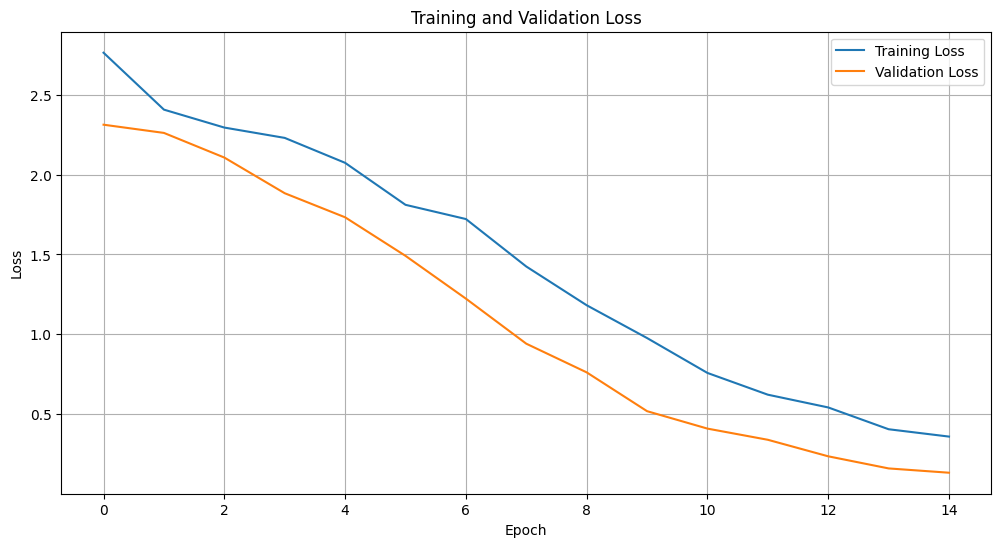

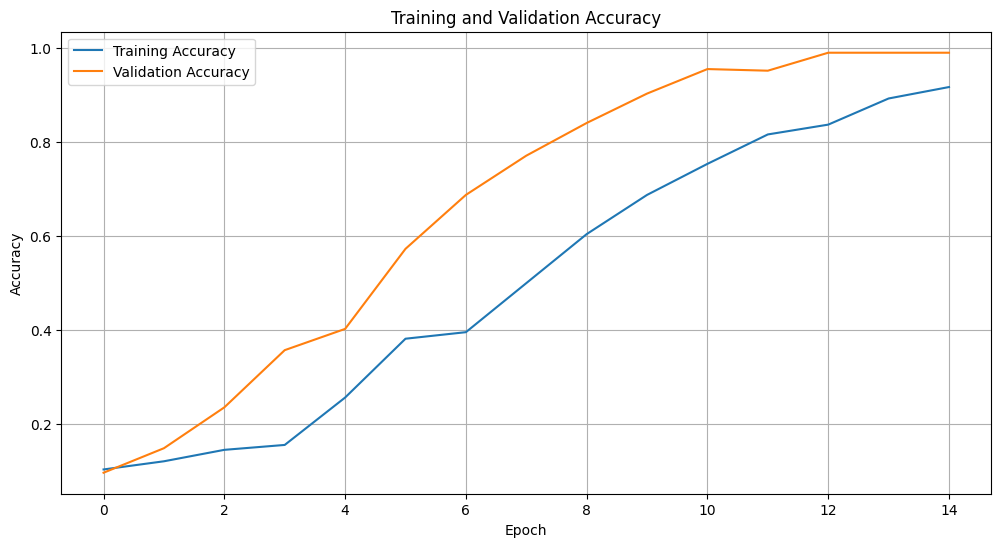

In [8]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


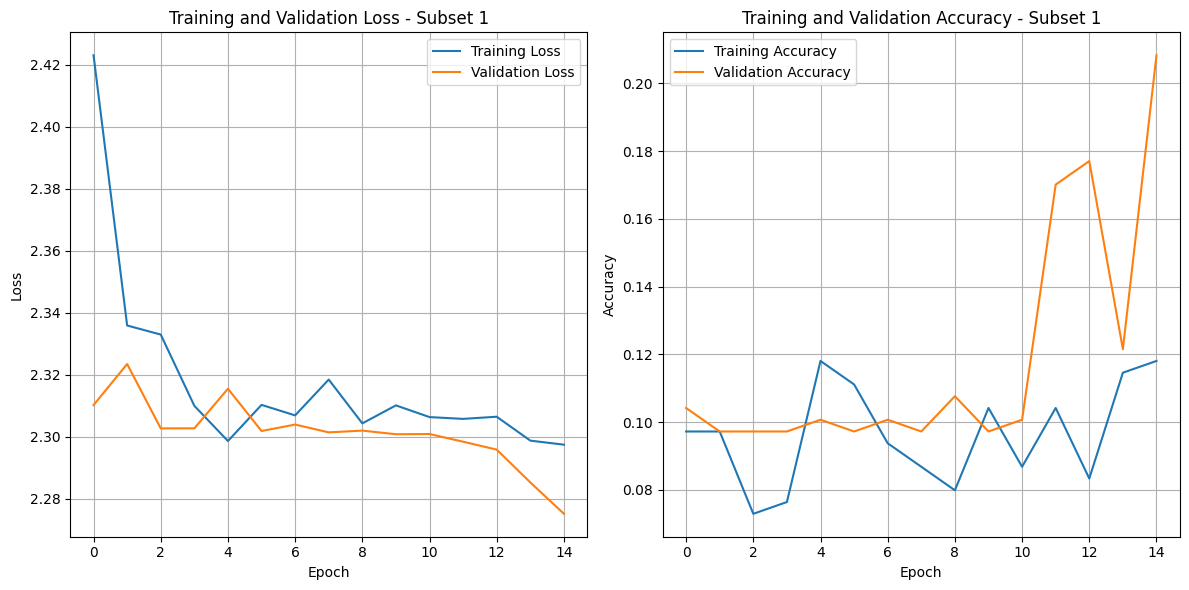

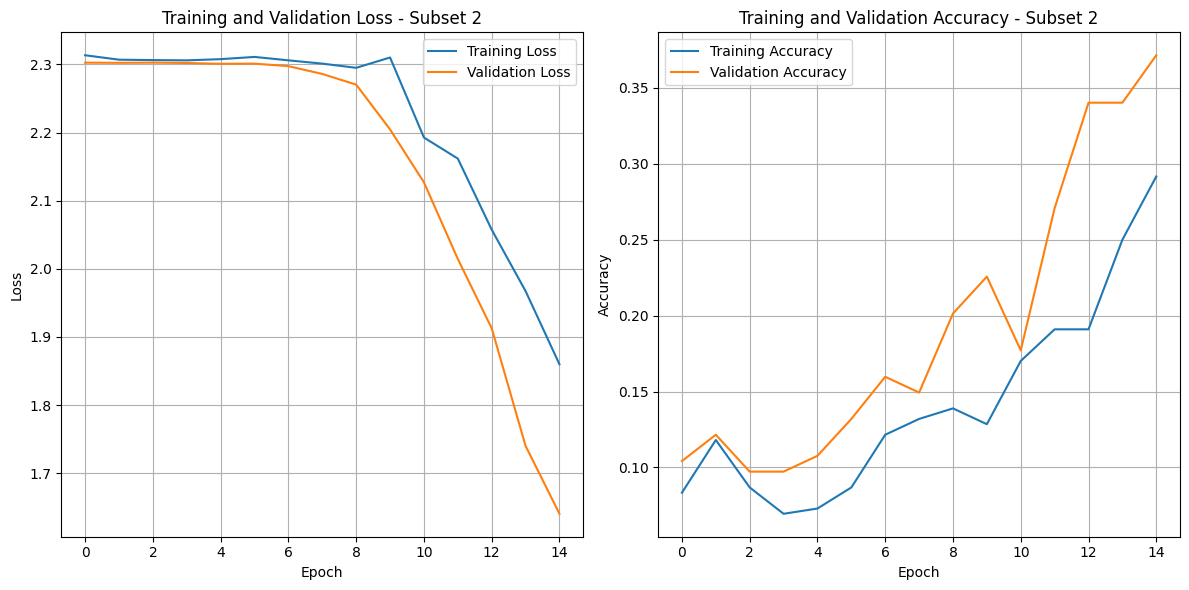

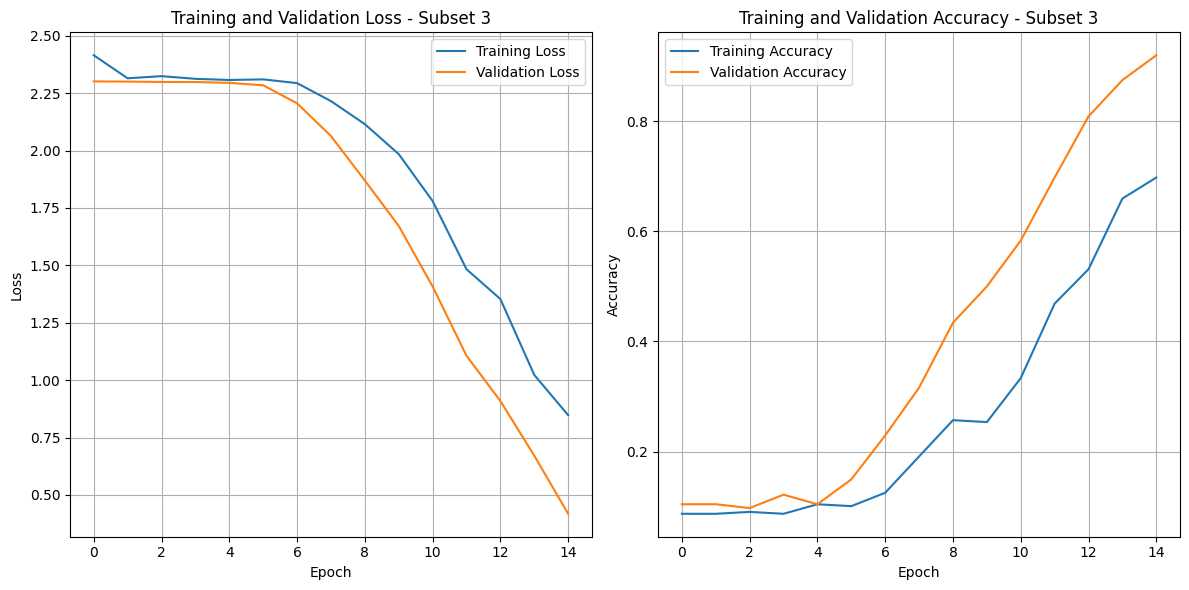

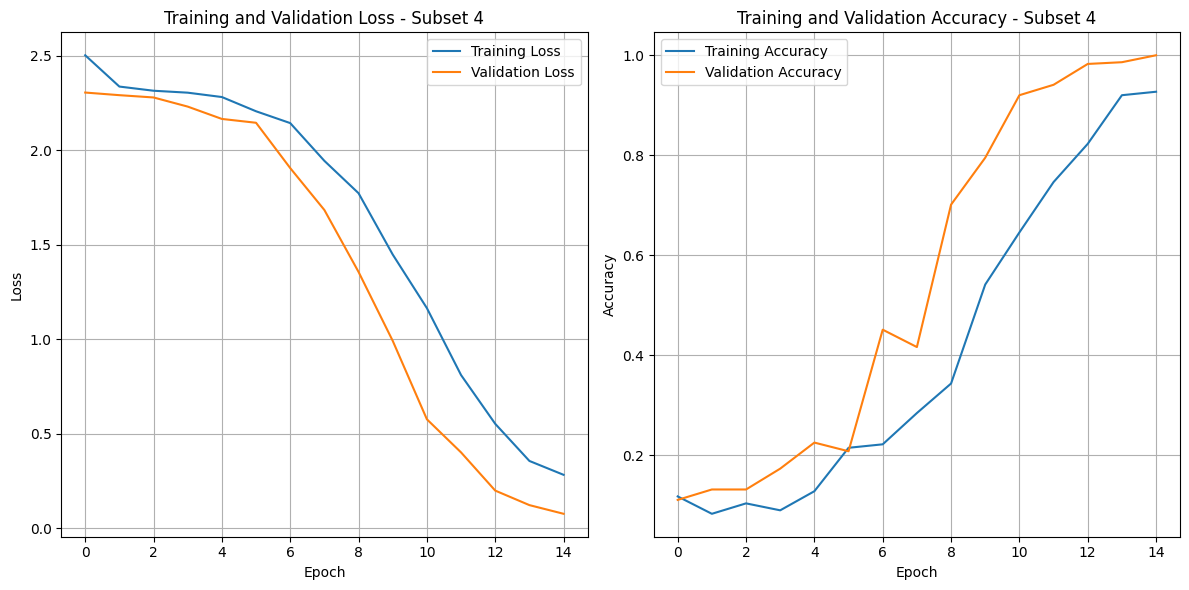

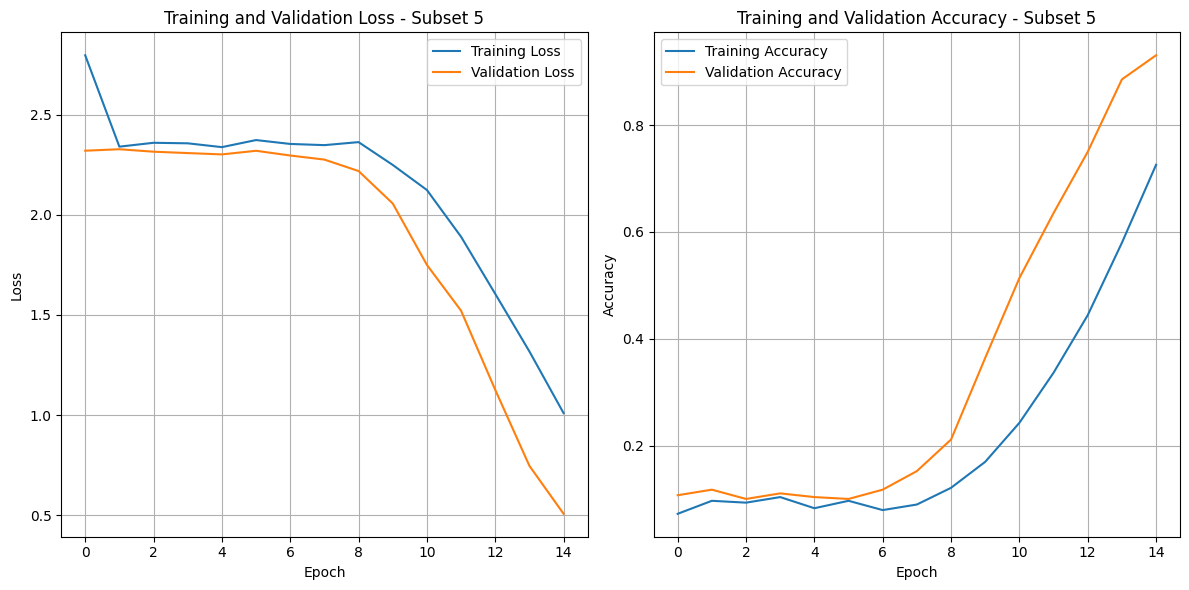

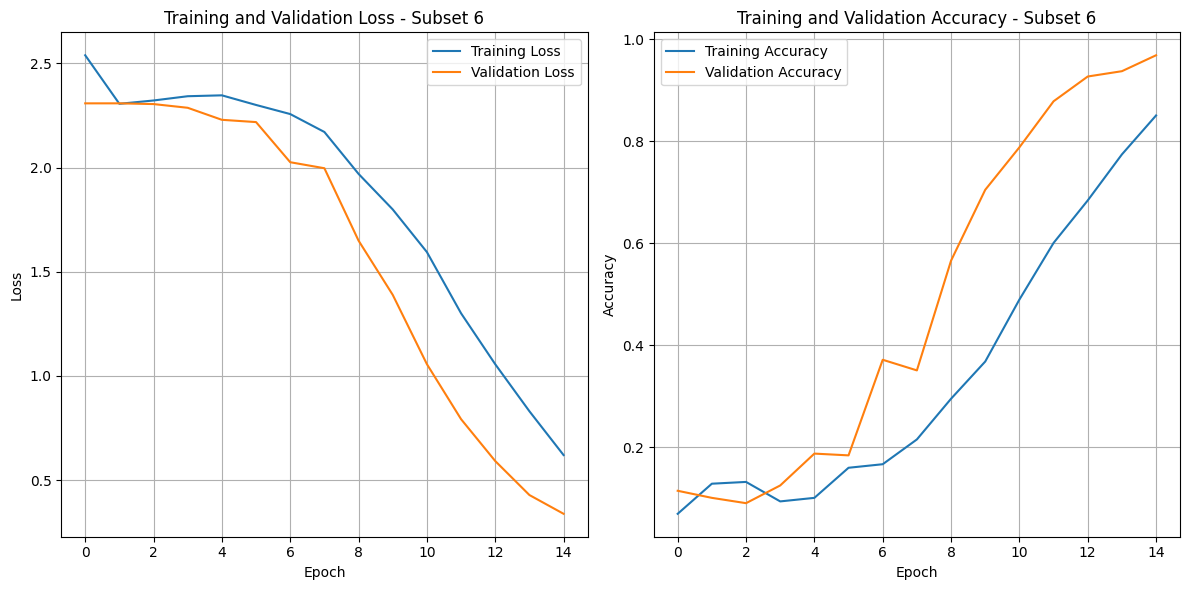

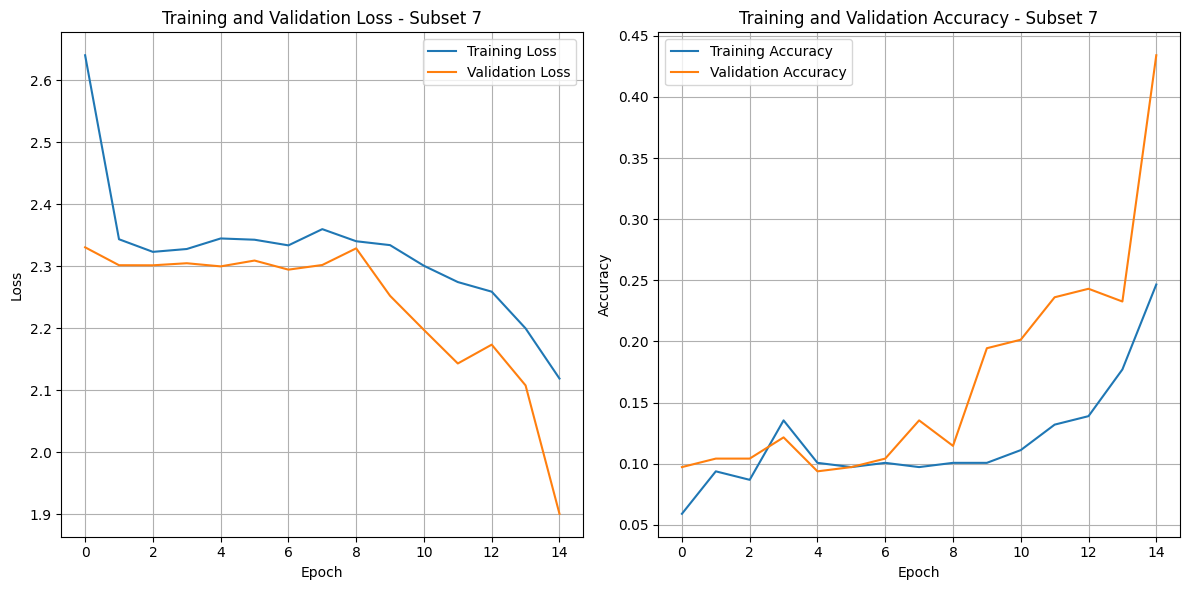

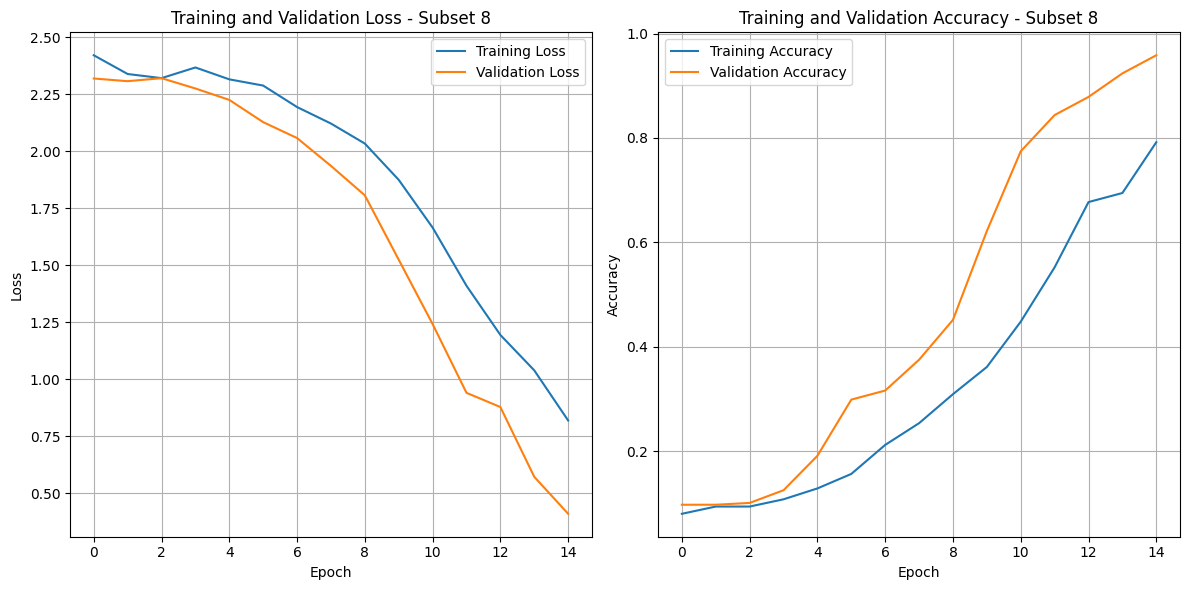

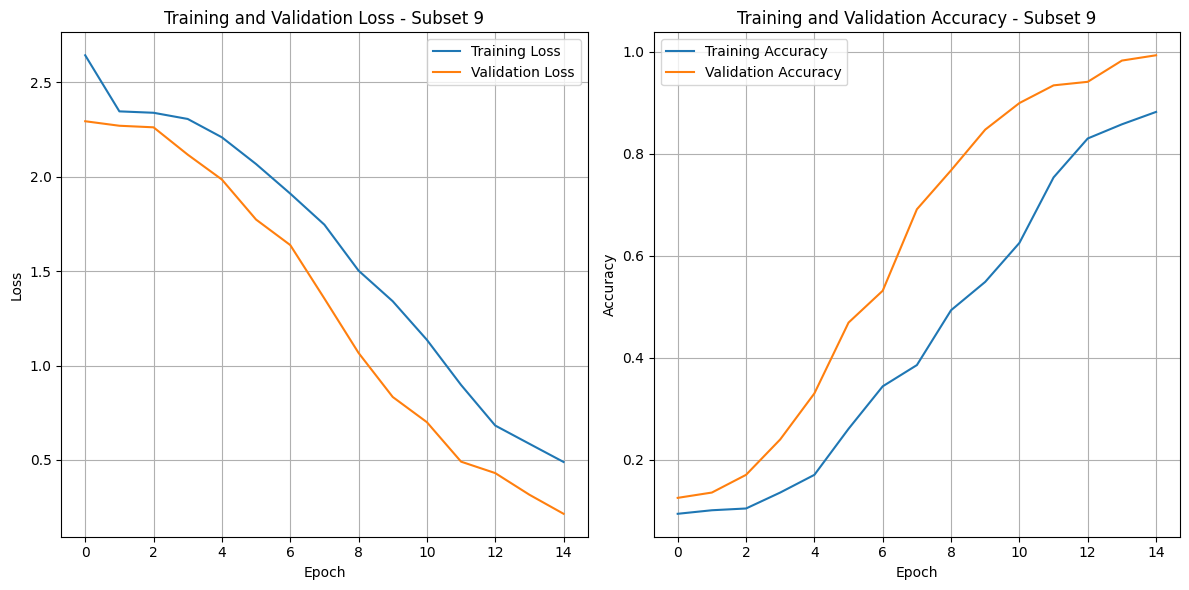

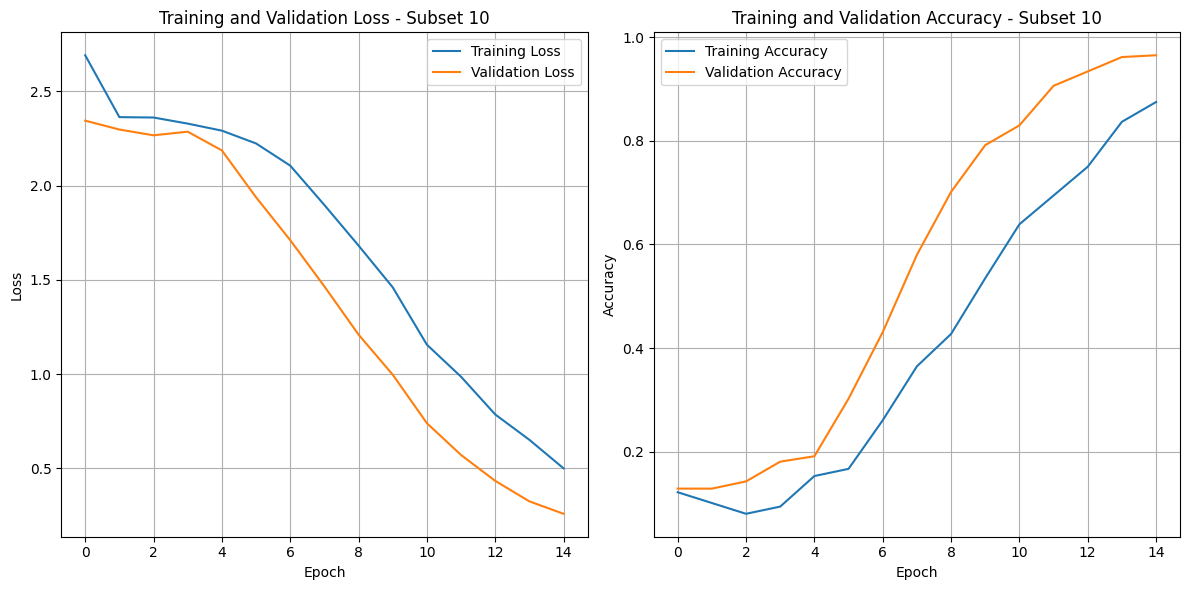

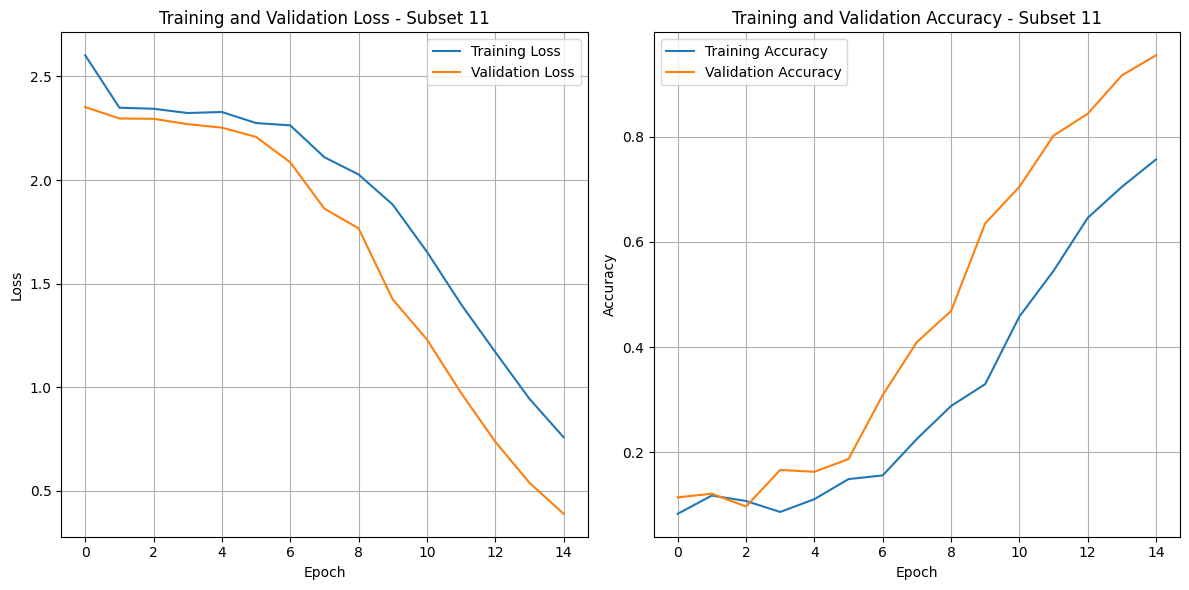

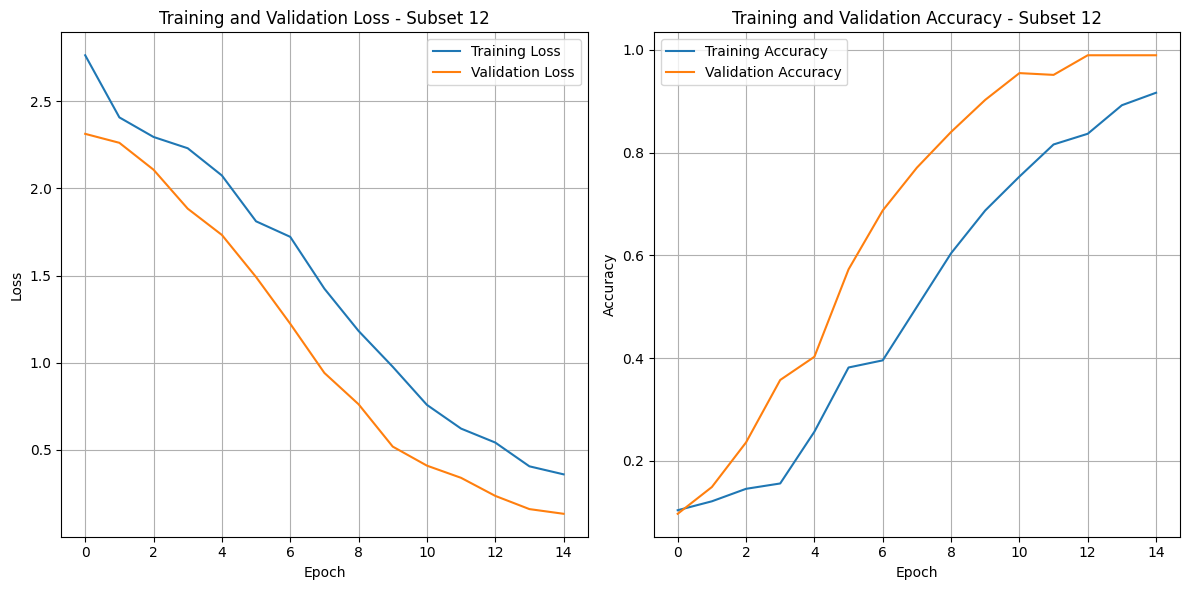

In [9]:
import matplotlib.pyplot as plt

# Plot loss and accuracy for each subset
for i in range(len(classes_subsets)):
    plt.figure(figsize=(12, 6))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(train_val_data['train_losses'][i], label='Training Loss')
    plt.plot(train_val_data['val_losses'][i], label='Validation Loss')
    plt.title(f'Training and Validation Loss - Subset {i+1}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_val_data['train_accuracies'][i], label='Training Accuracy')
    plt.plot(train_val_data['val_accuracies'][i], label='Validation Accuracy')
    plt.title(f'Training and Validation Accuracy - Subset {i+1}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
